In [208]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_chroma import Chroma
from langchain_community.llms.ollama import Ollama
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

import uuid
import time

In [209]:
CHROMA_PATH = "genshin_db"
MODEL = "llama3.1"
EMBEDDING_MODEL = "mxbai-embed-large"

PROMPT_TEMPLATE = """
Below is a list of documents in MARKDOWN that you'll use to answer a question.
IMPORTANT: DO NOT USE ANY OF YOUR GENERAL KNOWLEDGE TO ANSWER THE QUESTION!
USE ONLY THE DOCUMENTS BELOW TO ANSWER THE QUESTION.
Documents: 
{documents} 

IGNORE ALL DOCUMENTS WITH IRRELEVANT TITLES.
If none of the documents are relevant or no documents are mentioned above, just say that you don't know and suggest the user to rephrase the question.
After answering the question, you can request the user to rephrase the question if they believe the answer is incorrect.
Be as DESCRIPTIVE as possible, using a maxiumum of six paragraphs and aggregating all information in your answer.
DO NOT MENTION ANY DOCUMENT REFERENCES OR JUSTIFICATIONS IN YOUR ANSWER!!! USE ALL INFORMATION THAT YOU KNOW!
Here is the user's question: {question}
Provide your answer below: 
"""

GRADE_DOC_TEMPLATE = """You are a grader assessing the relevance of a retrieved document in MARKDOWN to a user question. \n 
Here is the retrieved document. \n
Title of the document: {title}
Content of the document: {content} \n\n
Here is the user question: {question} \n

IF THE DOCUMENT TITLE IS NOT RELEVANT TO THE QUESTION AT ALL, GRADE IT AS NOT RELEVANT. \n
HOWEVER, IF THE DOCUMENT TITLE IS RELEVANT BUT THE DOCUMENT CONTENT DOES NOT PROVIDE USEFUL INFORMATION, ALSO GRADE IT AS NOT RELEVANT. \n
Give a precise score of three significant digits between 0 to 1 to indicate how relevant are the document and the document's title to the question. \n
Provide the score as a JSON with a single key 'score' and no preamble or explanation."""



In [210]:
# LLM for JSON output
json_model = Ollama(model=MODEL, temperature=0, format="json", keep_alive="10m")

# Prepare the Genshin wiki and guide databases.
embedding_function = OllamaEmbeddings(model=EMBEDDING_MODEL)
wiki_db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function, collection_name="wiki")
guide_db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function, collection_name="guide")

# Grading Prompt
grade_prompt = PromptTemplate(template=GRADE_DOC_TEMPLATE, input_variables=["title", "content", "question"])
retrieval_grader = grade_prompt | json_model | JsonOutputParser()

In [211]:
# LLM for generation
model = Ollama(model=MODEL, temperature=0, keep_alive="10m")

# Prompt
prompt = PromptTemplate(template=PROMPT_TEMPLATE, input_variables=["documents", "question"])
rag_chain = prompt | model | StrOutputParser()

In [212]:
class GraphState(TypedDict):
    question: str
    documents: List[str]
    response: str

def retrieve(state):
    print("---RETRIEVE---")
    start_time = time.time()
    question = state["question"]

    # Because the wiki web pages often overshadows the other web pages when querying, zip results from both the wiki web pages and the guide web pages
    # to allow the LLM to consider sources from both categories
    documents = [
        doc 
        for pair in zip(guide_db.similarity_search_with_score(question, k=25), wiki_db.similarity_search_with_score(question, k=25))
        for doc in pair
    ]
    # documents = wiki_db.similarity_search_with_score(question, k=50)
    documents = [doc for doc, _  in documents]

    print(f"Retrieval time: {time.time() - start_time:.3f} sec")
    return {"documents": documents, "question": question}

def grade_documents(state):
    print("---GRADE DOCUMENTS---")

    question = state["question"]
    documents = state["documents"]

    threshold = 0.5
    # Split documents into batches to grade documents in parallel
    batch_size = 5
    batch_docs = [
        [doc for doc in documents[i:i+batch_size]]
        for i in range(0, len(documents), batch_size)
    ]

    start_time = time.time()

    accepted_docs = []
    docs_read = 0
    for batch in batch_docs:
        dict_list = [{"question": question, "title": doc.metadata["title"], "content": doc.page_content} for doc in batch]
        # Grade documents simultaneously
        results = retrieval_grader.batch_as_completed(dict_list)

        for i, response in results:
            print(response["score"], batch[i].metadata["id"])
            try:
                if float(response["score"]) >= threshold:
                    accepted_docs.append(batch[i])
            except ValueError:
                continue
            docs_read += 1
            # Early stop if there is 10 accepted docs or at least one accepted doc after grading 20 docs
            if len(accepted_docs) == 10:
                print(f"Grading time: {time.time() - start_time:.3f} sec")
                return {"documents": accepted_docs, "question": question}
    
    print(f"Grading time: {time.time() - start_time:.3f} sec")
    return {"documents": accepted_docs, "question": question}

def generate(state):
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]
    documents = sorted(documents, key=lambda x: (x.metadata["id"].split('#')[0], int(x.metadata["id"].split('#')[1])))

    start_time = time.time()
    formatted_docs = "\n\n".join([f"<START DOCUMENT>\n{doc.page_content}\n<END DOCUMENT>" for doc in documents])
    generation = rag_chain.invoke({"documents": formatted_docs, "question": question})
    
    print(f"Generation time: {time.time() - start_time:.3f} sec")
    return {"documents": documents, "question": question, "response": generation}

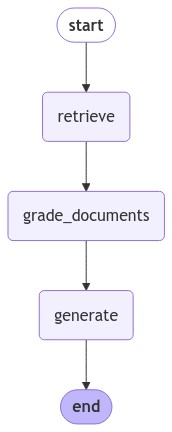

In [213]:
# Graph
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

# Edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [216]:
# Inference
def generate_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["question"]}, config
    )
    return {"response": state_dict["response"], "documents": [doc.metadata["id"] for doc in state_dict["documents"]]}


example = {"question": "What are all the constellations of Kachina? List them in bullet points."}
response = generate_answer(example)
print(response["response"])
print(response["documents"])

---RETRIEVE---
Retrieval time: 0.229 sec
---GRADE DOCUMENTS---
0.0 https://genshin-impact.fandom.com/wiki/Wangshan_Hall,_Secret_Chamber#11
0.001 https://game8.co/games/Genshin-Impact/archives/468199#1
0.999 https://traveler.gg/kachina-quick-character-guide/#5
0.000 https://genshin-impact.fandom.com/wiki/The_Arsenal#15
0.001 https://game8.co/games/Genshin-Impact/archives/462004#13
0.0 https://traveler.gg/navia-quick-character-guide/#3
0.000 https://genshin-impact.fandom.com/wiki/Tenryou_Commission_Headquarters#12
0.000 https://genshin-impact.fandom.com/wiki/Xigu_Antiques#13
0.000 https://traveler.gg/flowers-resplendent-on-the-sun-scorched-sojourn-version-5-0-update-details/#6
0.000 https://genshin-impact.fandom.com/wiki/Central_Hub#10
0.999 https://genshin.gg/characters/kachina/#3
0.0 https://genshin-impact.fandom.com/wiki/Sumeru_General_Goods#12
0.000 https://traveler.gg/kachina-quick-character-guide/#2
0.0 https://genshin-impact.fandom.com/wiki/Lumidouce_Harbor_Noticeboard#24
0.0 http